In [1]:
import pandas as pd
import markdown
from ydata_profiling import ProfileReport
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from statistics import mean
from sklearn.model_selection import train_test_split

C:\Users\Wihar\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Wihar\AppData\Roaming\Python\Python311\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [2]:
df=pd.read_csv("red_wine.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   citric acid  571 non-null    float64
 1   sulphates    571 non-null    float64
 2   alcohol      571 non-null    float64
 3   type         571 non-null    object 
dtypes: float64(3), object(1)
memory usage: 18.0+ KB


In [4]:
df.head()

,citric acid,sulphates,alcohol,type
0,0.49,0.63,8.0,low
1,0.66,0.57,8.3,low
2,0.23,0.44,8.5,high
3,0.44,0.84,8.6,low
4,0.08,0.50,8.7,low


In [5]:
profile = ProfileReport(df, title='Dataset Profile Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Cleaning

In [6]:
%matplotlib inline

<Axes: >

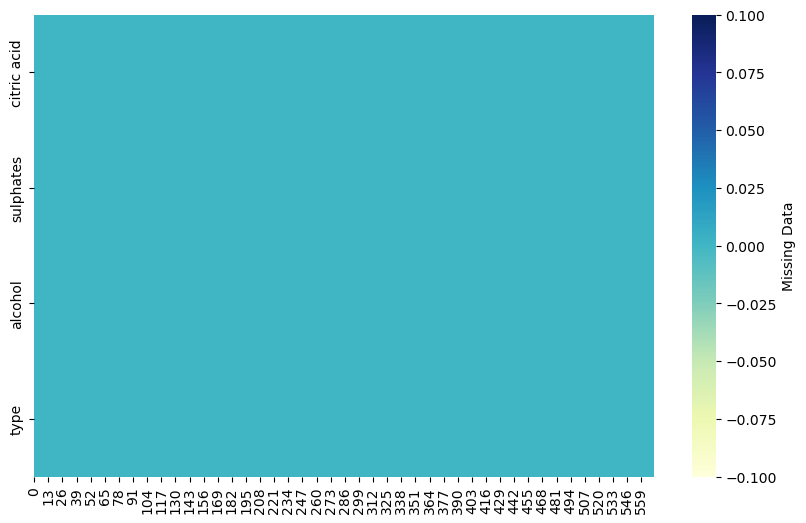

In [7]:
# Visualizing Missing Data using a seaborn heatmap.
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

- There is no missing data

<Axes: >

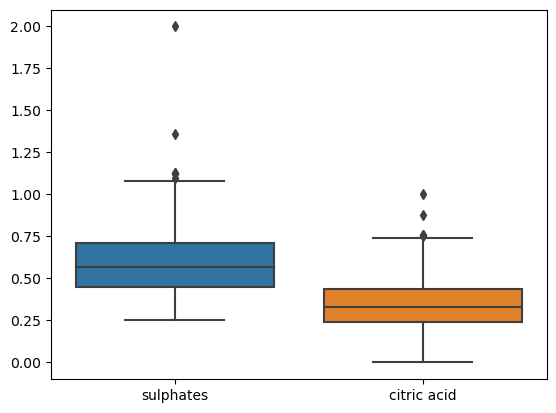

In [8]:
sns.boxplot(df[['sulphates','citric acid']])

<Axes: >

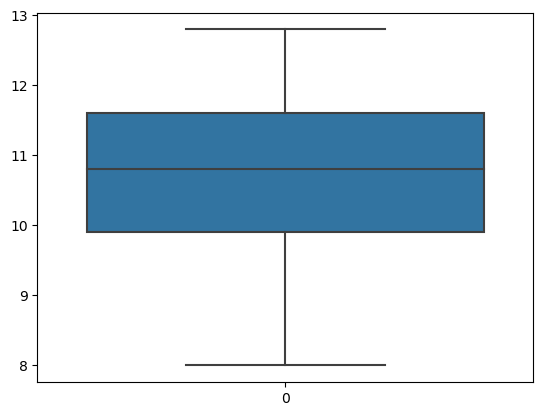

In [9]:
sns.boxplot(df['alcohol'])

- There is an outlier in sulphates column we can drop it

In [10]:
df['sulphates'].describe()

count    571.000000
mean       0.588161
std        0.188478
min        0.250000
25%        0.450000
50%        0.570000
75%        0.710000
max        2.000000
Name: sulphates, dtype: float64

In [11]:
df=df[df['sulphates']<2.0] #removing outlier

In [12]:
#Removing 13 duplicate rows in te data
df = df.drop_duplicates().reset_index(drop=True)

In [13]:
profile = ProfileReport(df, title='Dataset Profile Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
%matplotlib inline

In [15]:
X = df.drop("type", axis=1)
y = df["type"]
y=y.map({'high': 1, 'low': 0})
models = {
    "Baseline": None,  # Baseline model doesn't require a model
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM-Linear": SVC(kernel="linear"),
    "SVM-RBF": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier()
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)


for model_name, model in models.items():
    if model is None:
        # Baseline model
        predicted = y.mode().values[0]
        accuracy_scores = [accuracy_score(y, [predicted] * len(y))] * 10
        auc_scores = [0.5] * 10
    else:
        accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring="accuracy")
        auc_scores = cross_val_score(model, X, y, cv=kf, scoring="roc_auc")

    print(f"Model: {model_name}")
    print(f"Accuracy: Mean = {mean(accuracy_scores):.2f}")
    print(f"AUC: Mean = {mean(auc_scores):.2f}")
    print()


Model: Baseline
Accuracy: Mean = 0.52
AUC: Mean = 0.50

Model: Logistic Regression
Accuracy: Mean = 0.78
AUC: Mean = 0.87

Model: Naive Bayes
Accuracy: Mean = 0.82
AUC: Mean = 0.89

Model: Decision Tree
Accuracy: Mean = 0.80
AUC: Mean = 0.80

Model: SVM-Linear
Accuracy: Mean = 0.79
AUC: Mean = 0.87

Model: SVM-RBF
Accuracy: Mean = 0.53
AUC: Mean = 0.86

Model: Random Forest
Accuracy: Mean = 0.83
AUC: Mean = 0.92



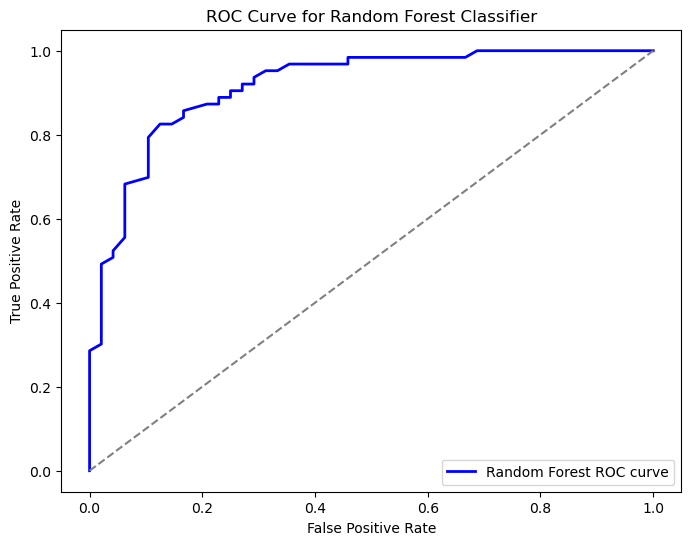

In [16]:
best_rf_model = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_rf_model.fit(X_train, y_train)

y_proba = best_rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='Random Forest ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

In [17]:
white_wine_data = pd.read_csv("white_wine.csv")

X_white = white_wine_data.drop("type", axis=1)
y_white = white_wine_data["type"]
y_white=y_white.map({'high': 1, 'low': 0})

best_rf_model = RandomForestClassifier()

best_rf_model.fit(X, y)

y_white_proba = best_rf_model.predict_proba(X_white)[:, 1]

auc_score = roc_auc_score(y_white, y_white_proba)

print(f"AUC Score on white-wine dataset: {auc_score:.2f}")

AUC Score on white-wine dataset: 0.97


- An AUC score close to 1.0 indicates that the model is performing very well in distinguishing between the high and low quality of wines when providing with unseen data. This high AUC score suggests that the model has a strong ability to discriminate between the quality of wines, and it's making accurate predictions.